In [1]:
import sys
sys.path.append('C:/IDE/repository/liquid_vapor_database')
from src.pdf_image_extractor import PDFImageExtractor
from src.pdf_page_processor import Page



# Путь к PDF файлу и путь к Tesseract
NUM_PAGE = 169
pdf_path = 'C:/IDE/repository/liquid_vapor_database/data/Kogan_1.pdf'
tesseract_path = 'C:/Program Files/Tesseract-OCR/tesseract.exe'
image = PDFImageExtractor(pdf_path, tesseract_path, images_folder=f'pdf_data/page_{NUM_PAGE}')        
page = Page(NUM_PAGE, image)

Обработка страницы 169


In [22]:
import pandas as pd
import easyocr 
import sys
sys.path.append('C:/IDE/repository/liquid_vapor_database/src')
from column_names_detector import ColumnLineDetector

PAGE_NUM = 169
img_path = f'C:/IDE/repository/liquid_vapor_database/pdf_data/page_{PAGE_NUM}/page_{PAGE_NUM}_processed.png'

reader = easyocr.Reader(['ru', 'en'])
result = reader.readtext(img_path)
easyocr_df = pd.DataFrame(result, columns=['bbox','text','conf'])
detector = ColumnLineDetector(img_path, easyocr_df, debug=True)
detector.detect_column_names_area()

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[(140, 1757, 1654, 1764),
 (647, 792, 1148, 794),
 (434, 986, 1345, 987),
 (111, 1902, 1590, 1904),
 (384, 1126, 1242, 1127),
 (81, 193, 1646, 196),
 (162, 335, 1644, 337),
 (632, 833, 1128, 836)]

In [23]:
import cv2
import re

img = cv2.imread(img_path)

def is_number(s):
    try:
        float(s)  # для чисел с плавающей точкой
        return True
    except ValueError:
        return False
    
# Перебрать все ограничивающие рамки и нарисовать их на изображении
for index, row in easyocr_df.iterrows():
    # Получение координат из bbox
    bbox = row['bbox']
    top_left = (int(bbox[0][0]), int(bbox[0][1]))
    bottom_right = (int(bbox[2][0]), int(bbox[2][1]))

    # Проверка текста на наличие только чисел
    if is_number(row['text']):
        color = (0, 255, 0)  # Зеленый, если текст - число
    else:
        color = (0, 0, 255)  # Красный, если текст содержит буквы

    # Рисование прямоугольника на изображении
    img = cv2.rectangle(img, top_left, bottom_right, color, 2)

# Сохранить изображение
cv2.imwrite(img_path.replace('.png', '_bbox.png'), img)

True

In [18]:
print(easyocr_df['text'][5])

SiCla


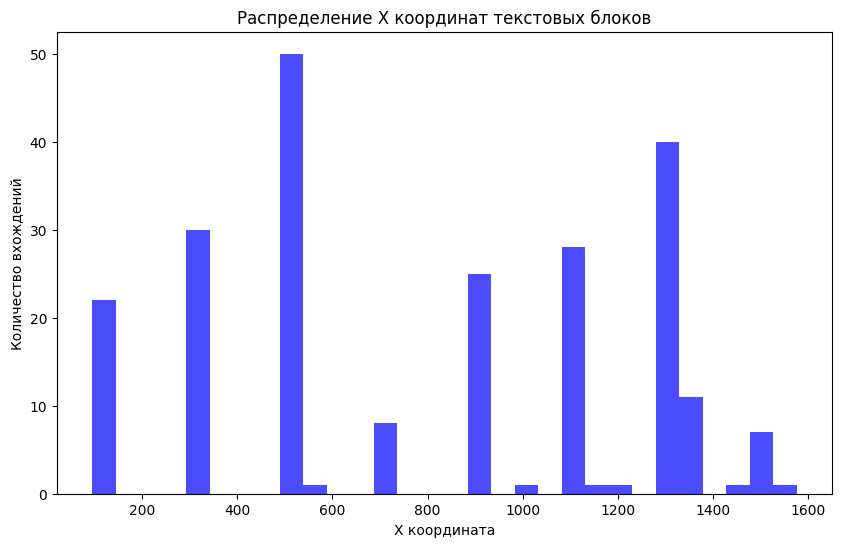

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Предположим, что easyocr_df - это ваш DataFrame, содержащий результаты easyOCR.
# bbox колонка содержит координаты в формате [[x_tl, y_tl], [x_br, y_br], ...]

# Шаг 1: Извлечение координат X
X = [((box[0][0] + box[2][0]) / 2) for box in easyocr_df['bbox']]  # Средние X координаты для каждого bbox

# Шаг 2: Построение гистограммы
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(X, bins=30, color='blue', alpha=0.7)  # Вы можете настроить количество бинов в зависимости от размера изображения
plt.title('Распределение X координат текстовых блоков')
plt.xlabel('X координата')
plt.ylabel('Количество вхождений')
plt.show()


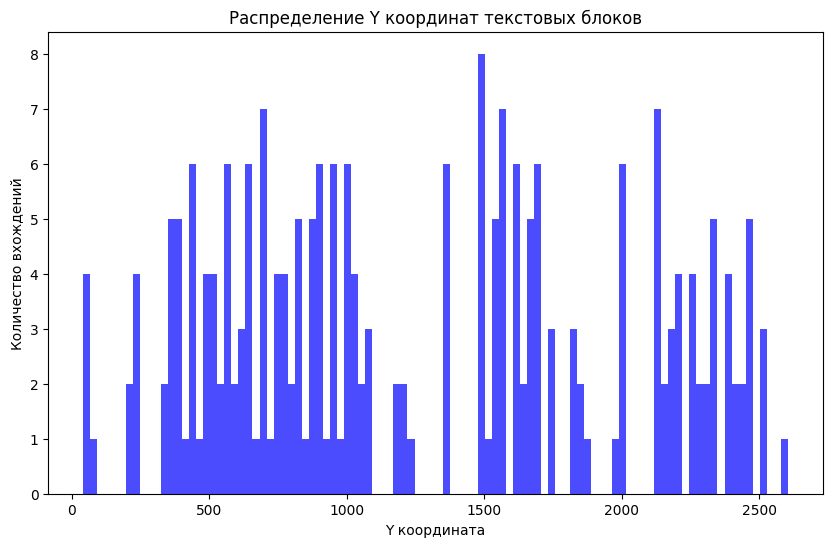

In [17]:
# Извлечение координат Y для каждого bbox и подготовка данных для гистограммы
Y = [((box[0][1] + box[1][1]) / 2) for box in easyocr_df['bbox']]  # Средние Y координаты для каждого bbox

# Построение гистограммы
plt.figure(figsize=(10, 6))
plt.hist(Y, bins=100, color='blue', alpha=0.7)
plt.title('Распределение Y координат текстовых блоков')
plt.xlabel('Y координата')
plt.ylabel('Количество вхождений')
plt.show()

In [5]:
easyocr_df['column_cluster']

0      4
1      4
2      2
3      0
4      3
      ..
225    0
226    2
227    5
228    0
229    4
Name: column_cluster, Length: 230, dtype: int32

In [10]:
import pandas as pd

# easyocr_df - предположим, что это ваш DataFrame с результатами OCR

# Пересчитать координаты для более простого доступа
easyocr_df['x_min'] = easyocr_df['bbox'].apply(lambda bbox: bbox[0][0])
easyocr_df['y_min'] = easyocr_df['bbox'].apply(lambda bbox: bbox[0][1])
easyocr_df['x_max'] = easyocr_df['bbox'].apply(lambda bbox: bbox[2][0])
easyocr_df['y_max'] = easyocr_df['bbox'].apply(lambda bbox: bbox[2][1])

# Сортировка по Y, затем по X координатам
sorted_df = easyocr_df.sort_values(by=['y_min', 'x_min'])

# Группировка текста по строкам с учетом допуска в Y координатах
grouped_lines = {}
line_threshold = 10  # допуск в пикселях для Y координаты, чтобы считать тексты одной строки

for _, row in sorted_df.iterrows():
    added = False
    for y in grouped_lines:
        if abs(y - row['y_min']) < line_threshold:
            grouped_lines[y].append((row['x_min'], row['text']))
            added = True
            break
            
    if not added:
        grouped_lines[row['y_min']] = [(row['x_min'], row['text'])]

# Формирование итогового текста с пробелами, соответствующими расстоянию между словами
output_text = []
for y in sorted(grouped_lines.keys()):
    texts = sorted(grouped_lines[y], key=lambda x: x[0])
    line_text = ""
    last_x_end = 0
    for x, text in texts:
        space_count = max((x - last_x_end) // 20 - len(text), 0)  # количество пробелов между словами
        line_text += ' ' * space_count + text
        last_x_end = x + len(text) * 20  # обновление последнего x конца с учетом добавленного текста
    output_text.append(line_text)

# Сохраняем строки в текстовый файл
with open("output_text.txt", "w", encoding="utf-8") as file:
    for line in output_text:
        file.write(line + "\n")


TypeError: can't multiply sequence by non-int of type 'float'

In [15]:
import cv2
import numpy as np

# Замените это путем к вашему изображению
image_path = 'C:/IDE/repository/liquid_vapor_database/pdf_data/page_133/page_133_processed.png'

# Загрузите изображение
img = cv2.imread(image_path)

# Предполагается, что easyocr_df - это ваш DataFrame
for index, row in easyocr_df.iterrows():
    bbox = row['bbox']
    text = row['text']

    # Находим координаты для текста: левый верхний угол и нижний правый
    (tl, tr, br, bl) = bbox
    tl = (int(tl[0]), int(tl[1]))
    br = (int(br[0]), int(br[1]))

    # Установите параметры для текста: шрифт, размер и т.д.
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    font_color = (0, 0, 255) # красный цвет
    font_thickness = 1

    # Нанесите текст на изображение
    img = cv2.putText(img, text, tl, font, font_scale, font_color, font_thickness, cv2.LINE_AA)

# Сохранить результат в файл
cv2.imwrite('C:/IDE/repository/liquid_vapor_database/pdf_data/page_133/page_133_processed_easyocr.png', img)

True

In [17]:
easyocr_df['text'].to_list()

['Ni',
 '1(',
 'ВОДОРОД_МЕТАН',
 '[258]',
 'H2CH4',
 '?',
 '9',
 't',
 'Р, ата',
 'T',
 'Р , ата',
 '2.4',
 '96.8',
 '-182.7',
 '49',
 '6.4',
 '-163.0',
 '78',
 '3.6',
 '97.5',
 '76',
 '7.7',
 '94.2',
 '90',
 '5.0',
 '96.9',
 '102',
 '8.5',
 '93.6',
 '97',
 '6.4',
 '139',
 '8.7',
 '91.9',
 '103',
 '8.1',
 '96.8',
 '164',
 '11.1',
 '91.2',
 '138',
 '8.2',
 '96.4',
 '171',
 '11.9',
 '92.0',
 '141',
 '94.8',
 '206',
 '15.6',
 '91.0',
 '187',
 '9.7',
 '94,4',
 '221',
 '3.2',
 '86.9',
 '_151.0',
 '36',
 '94.7',
 '_169.9',
 '39',
 '6.3',
 '92.5',
 '77',
 '2.2',
 '96.4',
 '77',
 '9.2',
 '91.1',
 '96',
 '5.1',
 '96.1',
 '104',
 '9.9',
 '89.8',
 '112',
 '111',
 '11.6',
 '88.8',
 '140',
 '5.2',
 '7',
 '95.8',
 '146',
 '16.2',
 '87,7',
 '187',
 '10.5',
 '95.7',
 '175',
 '3.8',
 '85.5',
 '~146.0',
 '37',
 '13.8',
 '94.2',
 '234',
 '6.7',
 '87.4',
 '62',
 '3.3',
 '92.6',
 '_163.0',
 '32',
 '9.3',
 '89.3',
 '85',
 '4.2',
 '92.7',
 '49',
 '14.3',
 '86.9',
 '131',
 '5.8',
 '93.6',
 '66',
 'Ni',
 '11',